# ACCESS Mid Depth Temperature

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33191/status,
Dashboard: /proxy/33191/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46353,Workers: 28
Dashboard: /proxy/33191/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:41751,Total threads: 1
Dashboard: /proxy/35231/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36325,


In [4]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean.nc'))

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

Up to here in ACCESS rewrite:

In [8]:
# Time variant variables
def preprocess(ds):
    ds = ds[['temp','salt','dzt']].sel(yt_ocean=slice(None,-55)).sel(st_ocean=slice(400,600))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [9]:
#Time slicing
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [10]:
cont['dzt']

<xarray.DataArray 'dzt' (time: 120, st_ocean: 4, yt_ocean: 584, xt_ocean: 3600)> Size: 4GB
dask.array<getitem, shape=(120, 4, 584, 3600), dtype=float32, chunksize=(2, 3, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
  * st_ocean  (st_ocean) float64 32B 423.7 468.4 517.6 571.6
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00
Attributes:
    long_name:      t-cell thickness
    units:          m
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  cell_thickness

In [11]:
#Time invariant variables
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']

We want to convert into conservative temperature to match ACCESS.  
We will need to:  
- (a) Calculate pressure from depths using `p_from_z` using `z_l` with a minus because the function has the z axis with zero at the surface and positive upwards
- (b) Calculate absolute salinity using `SA_from_SP`
- (c) Calculate conservative temperature using `CT_from_pt`

### Time mean for mapping

In [12]:
cont_map = cont.sel(time=slice('1915-01-01','1919-12-31')).mean(dim='time')
melt_map = melt.sel(time=slice('1915-01-01','1919-12-31')).mean(dim='time')

In [13]:
tempC = cont_map['temp']
tempM = melt_map['temp']

In [14]:
tempC

<xarray.DataArray 'temp' (st_ocean: 4, yt_ocean: 584, xt_ocean: 3600)> Size: 34MB
dask.array<mean_agg-aggregate, shape=(4, 584, 3600), dtype=float32, chunksize=(3, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
  * st_ocean  (st_ocean) float64 32B 423.7 468.4 517.6 571.6

In [15]:
tempC = tempC.load()#.astype('float32').load()

In [16]:
tempM = tempM.load()#.astype('float32').load()

#### Taking the depth mean

In [18]:
# Correcting area 
saltC = cont['salt']
saltM = melt['salt']

area_corr = area*(saltC.isel(time=0,st_ocean=0)*0 +1)

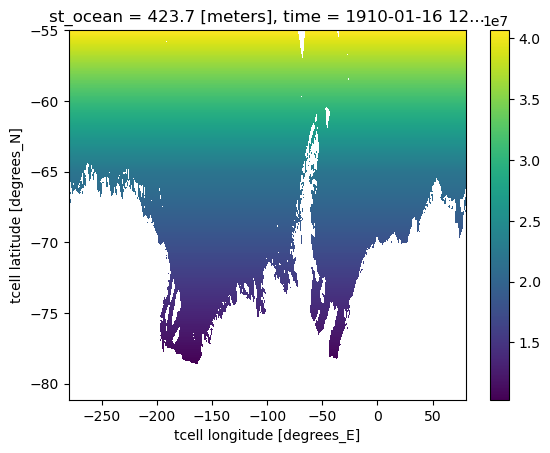

In [19]:
area_corr.plot()

In [20]:
thikC = cont['dzt']
thikM = melt['dzt']

In [21]:
thikC_map = cont_map['dzt'] 
thikM_map = melt_map['dzt']

In [22]:
thikC_map

<xarray.DataArray 'dzt' (st_ocean: 4, yt_ocean: 584, xt_ocean: 3600)> Size: 34MB
dask.array<mean_agg-aggregate, shape=(4, 584, 3600), dtype=float32, chunksize=(3, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01
  * st_ocean  (st_ocean) float64 32B 423.7 468.4 517.6 571.6

In [23]:
tempC_mid_map = tempC.weighted(thikC_map.fillna(0)).mean('st_ocean')
tempM_mid_map = tempM.weighted(thikM_map.fillna(0)).mean('st_ocean')

In [24]:
tempC_mid_map = tempC_mid_map.load()

In [25]:
tempM_mid_map = tempM_mid_map.load()

In [26]:
temp_anom_mid = tempM_mid_map - tempC_mid_map
temp_anom_mid = temp_anom_mid.load()

In [27]:
temp_anom_mid

<xarray.DataArray 'temp' (yt_ocean: 584, xt_ocean: 3600)> Size: 8MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.05456543, 0.05490112, 0.04940796, ..., 0.04553223, 0.04870605,
        0.05108643],
       [0.05593872, 0.05175781, 0.04400635, ..., 0.04629517, 0.05059814,
        0.05383301],
       [0.05392456, 0.0446167 , 0.03820801, ..., 0.04876709, 0.0536499 ,
        0.05679321]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01

#### Mapping

In [28]:
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
projection = ccrs.SouthPolarStereo()

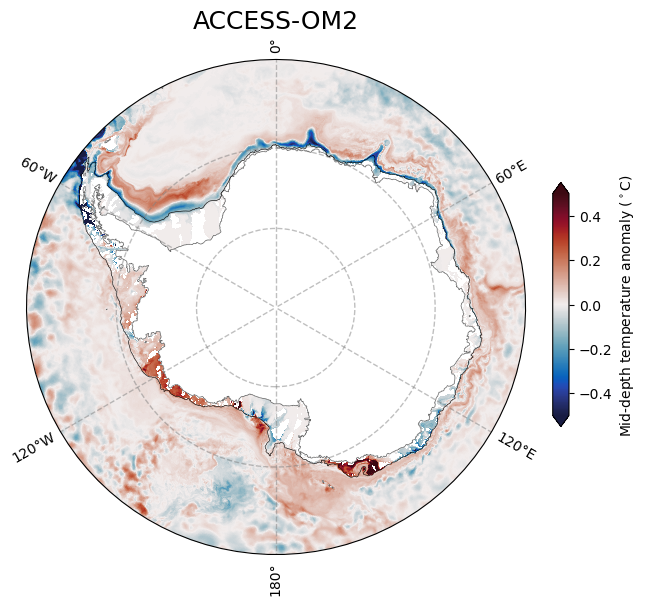

In [44]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.4,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
temp_anom_mid.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-0.5,
    vmax=0.5,
    extend="both",
    cmap= cm.cm.balance,
    cbar_kwargs={"label": "Mid-depth temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2",fontsize=18);

## Time series

#### Time series

In [31]:
tempC=cont['temp']
tempM=melt['temp']

In [32]:
# Depth average
tempC_mid = (thikC * tempC).sum(['st_ocean']) / thikC.sum(['st_ocean'])
tempM_mid = (thikM * tempM).sum(['st_ocean']) / thikM.sum(['st_ocean'])

In [33]:
# Just shelf 
tempC_shelf = tempC_mid.where(shelf_mask == 1)
tempM_shelf = tempM_mid.where(shelf_mask == 1)

In [34]:
tempC_shelf.astype('float32').isel(time=0)

<xarray.DataArray (yt_ocean: 510, xt_ocean: 3600)> Size: 7MB
dask.array<getitem, shape=(510, 3600), dtype=float32, chunksize=(146, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    time      object 8B 1910-01-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

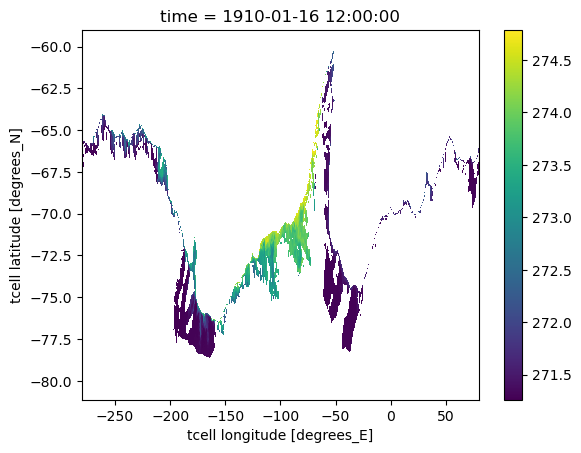

In [35]:
tempC_shelf.astype('float32').isel(time=0).plot()

In [36]:
# Spatial average
tempC_time = (area_corr * tempC_shelf).sum(['xt_ocean', 'yt_ocean']) / area_corr.sum(['xt_ocean', 'yt_ocean'])
tempM_time = (area_corr * tempM_shelf).sum(['xt_ocean', 'yt_ocean']) / area_corr.sum(['xt_ocean', 'yt_ocean'])

In [37]:
tempC_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 423.7
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [38]:
tempC_time = tempC_time.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/dask/_task_spec.py:755: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

In [39]:
tempM_time = tempM_time.load()

Text(0.5, 1.0, 'ACCESS-OM2 Time Series of Mid-depth Temperature on Shelf')

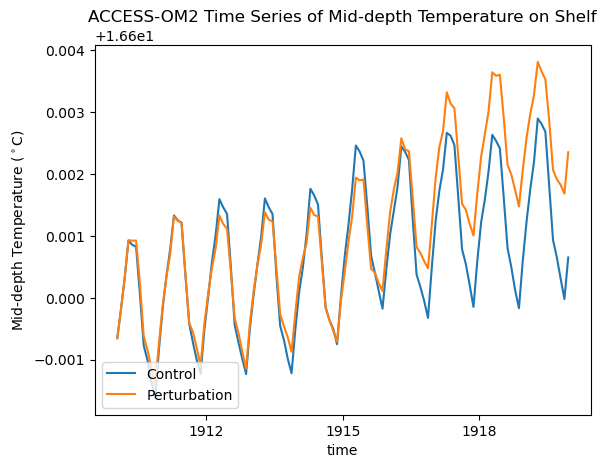

In [40]:
tempC_time.plot(label="Control")
tempM_time.plot(label="Perturbation")
plt.ylabel("Mid-depth Temperature ($^\circ$C)")
plt.legend(loc="lower left")
plt.title("ACCESS-OM2 Time Series of Mid-depth Temperature on Shelf")

In [41]:
midtemp_anom_time = tempM_time - tempC_time
midtemp_anom_time = midtemp_anom_time.load()

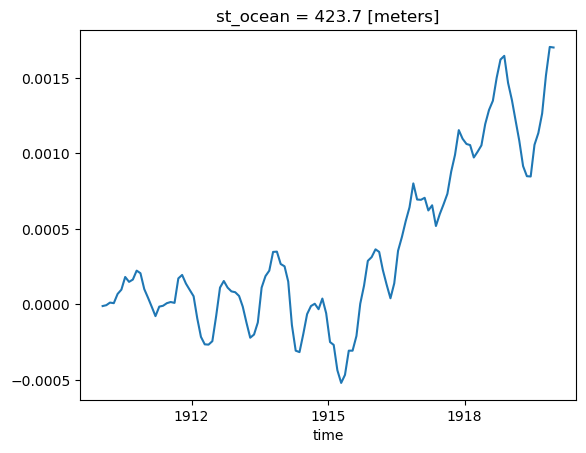

In [42]:
midtemp_anom_time.plot()

In [43]:
midtemp_anom_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/midtemp_anom_prescribed_access.nc')